We shall start by importing the essential libraries.

In [1]:
### IMPORTING LIBRARIES
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import collections
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import plot_confusion_matrix, classification_report, accuracy_score, recall_score, roc_curve, roc_auc_score
from sklearn.ensemble import RandomForestClassifier

Next, we clean the data and bring it to a form which will make the model building process easy. This phase is done exactly the same way as in 00 - Stroke EDA.

In [2]:
### DATA PREPARATION
stroke = pd.read_csv('C:\\Users\\Shekhar Lamba\\Documents\\Datasets\\healthcare-dataset-stroke-data.csv', na_values = [np.NaN, ' '])

df = pd.DataFrame(stroke)
df = df.drop(['id'], axis = 1)

num_vars = df.select_dtypes(include = ['int64', 'float64'])
cat_vars = df.select_dtypes(include = 'object')
feature_names = collections.defaultdict(str)
for name in num_vars.columns:
    feature_names[name]
for name in cat_vars.columns:
    feature_names[name]

mean_imputer = SimpleImputer(strategy = 'mean')
imputed_vars = mean_imputer.fit_transform(num_vars)
df_imputed = pd.DataFrame(np.hstack([imputed_vars, cat_vars]), columns = feature_names)

df_imputed['age'] = df_imputed['age'].astype('float64')
df_imputed['hypertension'] = df_imputed['hypertension'].astype('int64')
df_imputed['heart_disease'] = df_imputed['heart_disease'].astype('int64')
df_imputed['avg_glucose_level'] = df_imputed['avg_glucose_level'].astype('float64')
df_imputed['bmi'] = df_imputed['bmi'].astype('float64')
df_imputed['stroke'] = df_imputed['stroke'].astype('int64')

capping = num_vars.select_dtypes(include = 'float64')
for col in df_imputed.columns:
    if col in capping.columns:
        percentile = df_imputed[col].quantile([0.05, 0.95]).values
        df_imputed[col] = df_imputed[col].clip(lower = percentile[0], upper = percentile[1])
        
df_final = pd.get_dummies(df_imputed, columns = ['gender', 'ever_married', 'work_type', 'Residence_type',
                                              'smoking_status'], drop_first = True)

Now we separate the independent and dependent features; we label them X and y respectively. Then, we separate data for training and testing sets in the ratio of 8:2, making sure that the imbalance in the levels of the target variable, y, is maintained in both the sets. In other words, both the training and testing sets have the same proportion of people who did not suffer from stroke and those who did.

In [3]:
### SEPARATING TRAIN AND TEST SETS
X = df_final.drop(['stroke'], axis = 1)
y = df_final['stroke']
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y, test_size = 0.2, random_state = 99)

We now go on to make a simple Random Forest model, which will serve as our baseline. Remember that the data was highly unbalanced in that the number of people who did not suffer from stroke was far more than those who did. To overcome this problem, we simply set the weights of the levels of y as balanced. What this does is that it assigns weights to the two levels of y, the weight of each level being inversely proportional to its frequency.

We also tell our model to calculate the Out-of-Bag score which will later help us to get the Out-of-bag error. The oob error is the proportion of data points which was left out during the process of bootstrapping while creating the random forest and was incorrectly labelled by those trees in the forest which did not consider them during their initial construction.

So, we build the model with class weights as balanced and oob_score as true, fit it to the training data and plot the confusion matrix.

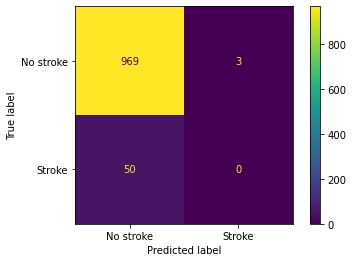

In [4]:
### CREATING A BASELINE MODEL
clf_rf = RandomForestClassifier(random_state = 99, class_weight = 'balanced', oob_score = True, n_jobs = -1)
clf_rf.fit(X_train, y_train)
plot_confusion_matrix(clf_rf, X_test, y_test, display_labels = ['No stroke', 'Stroke'])

Before we proceed, let us first take a look at the distribution of the levels of y in our dataset.

In [5]:
df['stroke'].value_counts(normalize = True)

0    0.951272
1    0.048728
Name: stroke, dtype: float64

Here, we see that around 95% of the people in our dataset have not suffered from stroke as opposed to just about 5% who actually have. This means that even if our model predicts every person as not having a stroke, the model will still be 95% accurate at the very least. So, in this case, accuracy is a deceptive metric. 


What we should rather be concerned with is the number of people who actually had stroke but were not identified by the model as having stroke i.e. the False Negatives. Lower the FN value, lower is the risk of overlooking a possible case of stroke and thus better is the model because the main objective of the model here should be to possibly save lives by correctly identifying a stroke case as early as possible. To reduce the FN value, we need to ensure that the recall of stroke cases is high since recall and FN are inversely proportional.


So, we shall calculate the accuracy, recall score and oob error for the predictions made by the model.

In [6]:
### CALCULATING ESSENTIAL METRICS
y_pred_rf = clf_rf.predict(X_test)
print(classification_report(y_test, y_pred_rf, target_names = ['No stroke', 'Stroke']))
print('Accuracy: %f' % accuracy_score(y_test, y_pred_rf))
print('Recall score: %f' % recall_score(y_test, y_pred_rf))
print('OOB error: %f' % (1 - clf_rf.oob_score_))

              precision    recall  f1-score   support

   No stroke       0.95      1.00      0.97       972
      Stroke       0.00      0.00      0.00        50

    accuracy                           0.95      1022
   macro avg       0.48      0.50      0.49      1022
weighted avg       0.90      0.95      0.93      1022

Accuracy: 0.948141
Recall score: 0.000000
OOB error: 0.050147


If we look at the confusion matrix, we see that out of the 50 cases that had actually suffered from stroke, none of them were correctly predicted as having a stroke by our model. The baseline simply predicted all the stroke cases as not having a stroke. This gives us a recall score of just 0% while the accuracy is about 95%. Even though we have acheived great accuracy, the model is very poor. Also, the OOB error is 5%, which is again due to the model failing to predict the all the stroke cases which made up 5% of the total dataset.

Next, we plot the ROC curve and calculate the AUC score.

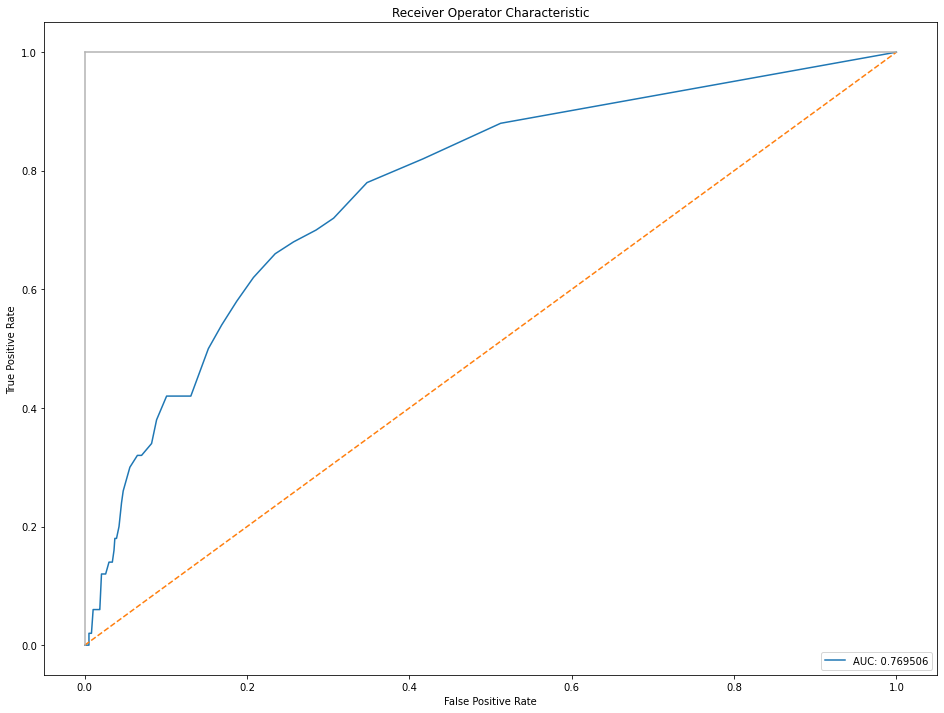

In [7]:
### PLOTTING ROC CURVE WITH AUC VALUE
y_prob_rf = clf_rf.predict_proba(X_test)[:, 1]
fpr, tpr, threshold = roc_curve(y_test, y_prob_rf)
roc_auc = roc_auc_score(y_test, y_prob_rf)
plt.figure(figsize = (16, 12))
plt.title('Receiver Operator Characteristic')
plt.plot(fpr, tpr, label = 'AUC: %f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], ls = '--')
plt.plot([0, 0], [1, 0], c = '0.7')
plt.plot([1, 1], c = '0.7')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

We get an AUC score of about 0.7695. The high score is probably due to the model correctly predicting all the non-stroke cases.


Random Forest also allows us to look at the variables that it considers important to the final outcome.

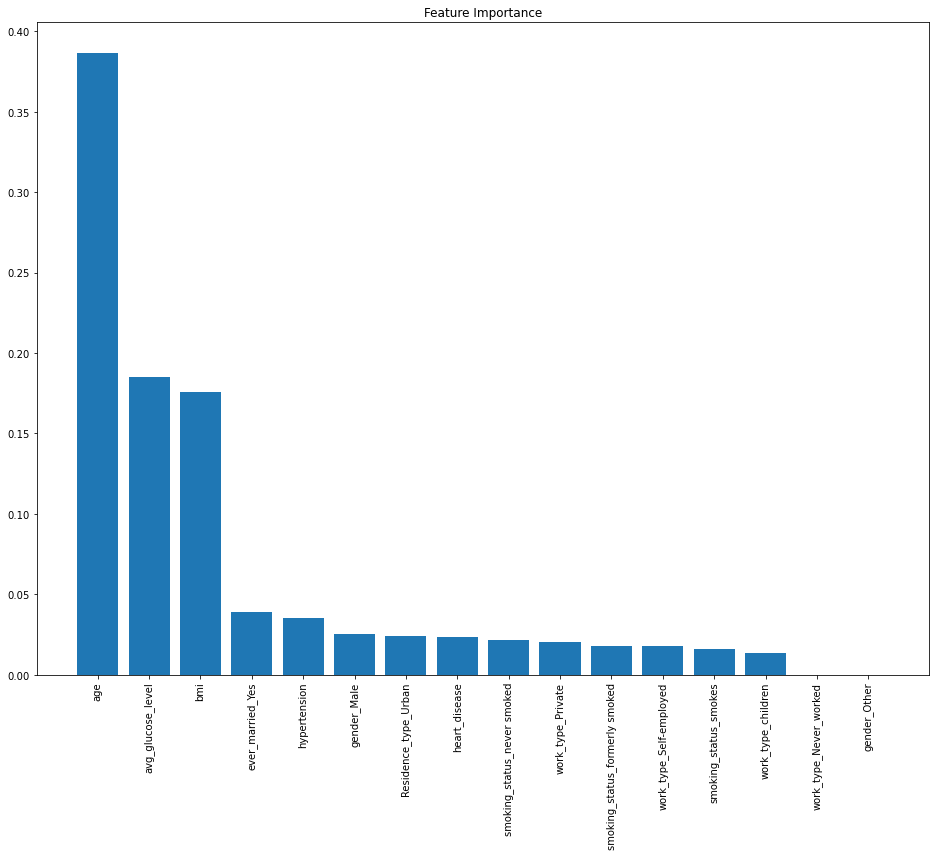

In [8]:
### PLOTTING FEATURE IMPORTANCE
importance = clf_rf.feature_importances_
indices = np.argsort(importance)[::-1]
names = [X.columns[i] for i in indices]
plt.figure(figsize = (16, 12))
plt.figure
plt.title('Feature Importance')
plt.bar(range(X.shape[1]), importance[indices])
plt.xticks(range(X.shape[1]), names, rotation = 90)
plt.show()

We see that age, average glucose level and bmi are considered to be very important. This may be due to the the range of their values bring larger than others which may have led to overfitting.


Next, we will try to further improve the model by tuning it's hyperparameters. For this, we shall use a random search with 3 fold cross-validation across the possible values for the following hyperparameters:
1. n_estimators: the number of trees in the forest
2. max_depth: the maximum number of levels in each tree in the forest
3. max_features: the maximum number of features to be considered while making a tree
4. min_samples_leaf: the minimum number of samples required to consider a node as a leaf
5. min_samples_split: the minimum number of samples required to further split a node 

As we are trying to decrease the FN value, we will use roc_auc as our scoring parameter.

In [9]:
### TUNING HYPERPARAMETER VALUES USING RANDOMIZED SEARCH
param_distributions = {
    'n_estimators': range(100, 1000, 100),
    'max_depth': range(3, 10),
    'max_features': range(3, 15),
    'min_samples_leaf': range(3, 20),
    'min_samples_split': range(3, 20)
}
rf = RandomForestClassifier(random_state = 99, class_weight = 'balanced')
random_fit = RandomizedSearchCV(estimator = rf,
                               param_distributions = param_distributions,
                               scoring = 'roc_auc',
                               cv = 3,
                               n_iter = 30,
                               verbose = 2,
                               random_state = 99,
                               n_jobs = -1)
random_fit.fit(X_train, y_train)
print(random_fit.best_params_)
print('Best score: %f' % random_fit.best_score_)

Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   39.5s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:  1.5min finished


{'n_estimators': 900, 'min_samples_split': 13, 'min_samples_leaf': 18, 'max_features': 9, 'max_depth': 4}
Best score: 0.847126


Now, with these tuned hyperparameter values, we shall create our second model.

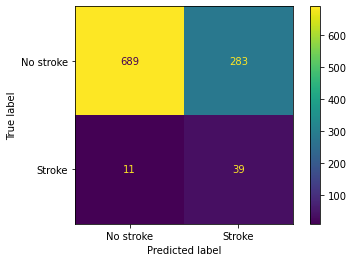

In [10]:
### CREATING THE IMPROVED MODEL
clf_rf = RandomForestClassifier(random_state = 99,
                               class_weight = 'balanced',
                               max_depth = 4,
                               max_features = 9,
                               min_samples_leaf = 18,
                               min_samples_split = 13,
                               n_estimators = 900,
                               oob_score = True,
                               n_jobs = -1)
clf_rf.fit(X_train, y_train)
plot_confusion_matrix(clf_rf, X_test, y_test, display_labels = ['No stroke', 'Stroke'])

Of the 50 stroke cases, 39 were correctly identified by the new model while 11 were mislabelled. This is much better than our baseline model.

In [11]:
### CALCULATING ESSENTIAL METRICS
y_pred_rf = clf_rf.predict(X_test)
print(classification_report(y_test, y_pred_rf, target_names = ['No stroke', 'Stroke']))
print('Accuracy: %f' % accuracy_score(y_test, y_pred_rf))
print('Recall score: %f' % recall_score(y_test, y_pred_rf))
print('OOB error: %f' % (1 - clf_rf.oob_score_))

              precision    recall  f1-score   support

   No stroke       0.98      0.71      0.82       972
      Stroke       0.12      0.78      0.21        50

    accuracy                           0.71      1022
   macro avg       0.55      0.74      0.52      1022
weighted avg       0.94      0.71      0.79      1022

Accuracy: 0.712329
Recall score: 0.780000
OOB error: 0.273973


The recall score gone up to 78% while the accuracy has reduced to about 71%, pointing to the already established fact that accuracy is a deceptive metric in this case. Also, the OOB error has increased to about 27.4% which is understandable since the baseline was predicting every case as non-stroke and so was correct 95% of the time. The OOB error of 27.4% signifies that when we ran samples through the trees which did not use those samples during their construction and gave them the value predicted by majority of trees, 27.4% of the samples were misclassified. 

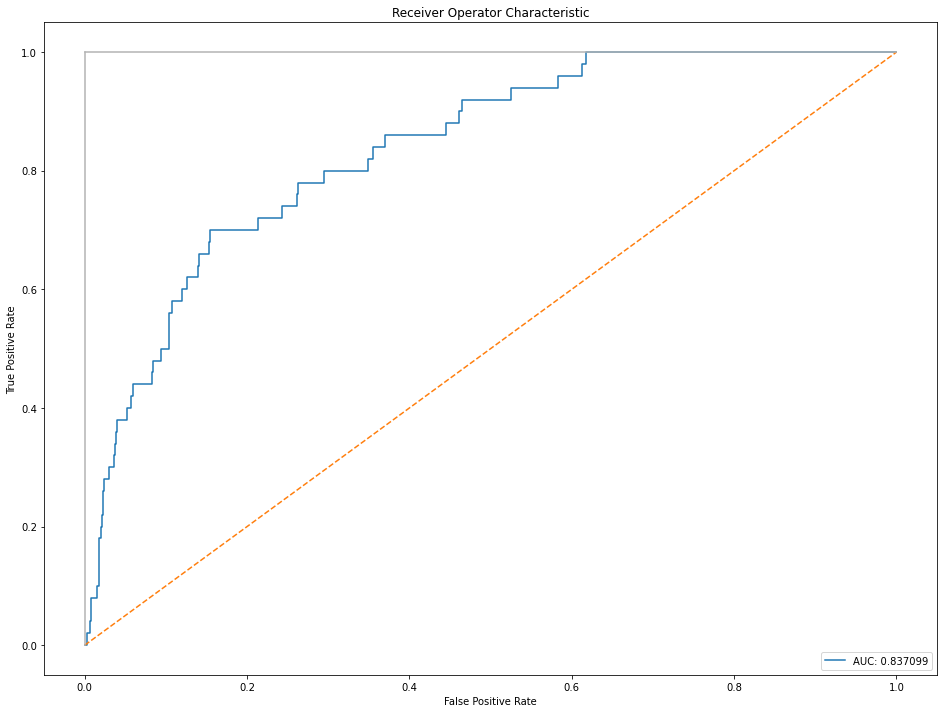

In [12]:
### PLOTTING ROC CURVE WITH AUC VALUE
y_prob_rf = clf_rf.predict_proba(X_test)[:, 1]
fpr, tpr, threshold = roc_curve(y_test, y_prob_rf)
roc_auc = roc_auc_score(y_test, y_prob_rf)
plt.figure(figsize = (16, 12))
plt.title('Receiver Operator Characteristic')
plt.plot(fpr, tpr, label = 'AUC: %f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], ls = '--')
plt.plot([0, 0], [1, 0], c = '0.7')
plt.plot([1, 1], c = '0.7')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

We get an AUC score of about 0.8371. Thus, we see that our new model is much better than our baseline.


We can also see the features deemed important by the model.

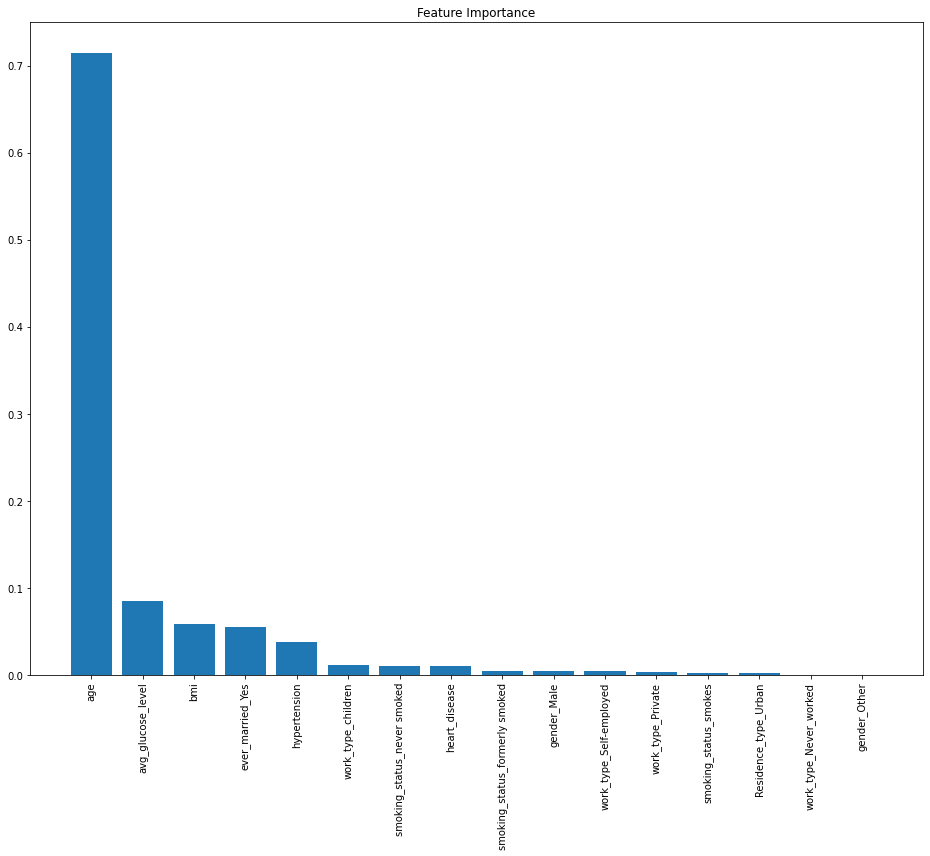

In [13]:
### PLOTTING FEATURE IMPORTANCE
importance = clf_rf.feature_importances_
indices = np.argsort(importance)[::-1]
names = [X.columns[i] for i in indices]
plt.figure(figsize = (16, 12))
plt.figure
plt.title('Feature Importance')
plt.bar(range(X.shape[1]), importance[indices])
plt.xticks(range(X.shape[1]), names, rotation = 90)
plt.show()

We see that while age has been considered as important as in the baseline, average glucose level and bmi have comparatively less importance than age in this model. Also, being a non-smoker has become a bit significant than it was earlier. 

To further improve this model, we shall again tune the hyperparameters but this time via a grid search with 3 fold cross-validation. The candidate values will be numbers close to the values predicted by the random search. We do this a couple of times making sure that we use a narrower range of values every time.

In [14]:
### TUNING HYPERPARAMETER VALUES USING RANDOMIZED SEARCH
# param_grid_1 = {
#     'n_estimators': [800, 900, 1000],
#     'max_depth': [3, 4, 5],
#     'max_features': [8, 9, 10],
#     'min_samples_leaf': [17, 18, 19],
#     'min_samples_split': [12, 13, 14]    
# }
# rf = RandomForestClassifier(random_state = 99, class_weight = 'balanced')
# grid_fit_1 = GridSearchCV(estimator = rf,
#                        param_grid = param_grid_1,
#                        scoring = 'roc_auc',
#                        cv = 3,
#                        verbose = 2,
#                        n_jobs = -1)
# grid_fit_1.fit(X_train, y_train)
# print(grid_fit_1.best_params_)
# print('Best score: %f' % grid_fit_1.best_score_)

In [15]:
param_grid_2 = {
    'n_estimators': [900],
    'max_depth': [4],
    'max_features': [10, 11],
    'min_samples_leaf': [19, 20],
    'min_samples_split': [11, 12]    
}
rf = RandomForestClassifier(random_state = 99, class_weight = 'balanced')
grid_fit_2 = GridSearchCV(estimator = rf,
                       param_grid = param_grid_2,
                       scoring = 'roc_auc',
                       cv = 3,
                       verbose = 2,
                       n_jobs = -1)
grid_fit_2.fit(X_train, y_train)
print(grid_fit_2.best_params_)
print('Best score: %f' % grid_fit_2.best_score_)

Fitting 3 folds for each of 8 candidates, totalling 24 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 out of  24 | elapsed:   38.2s finished


{'max_depth': 4, 'max_features': 11, 'min_samples_leaf': 20, 'min_samples_split': 11, 'n_estimators': 900}
Best score: 0.847753


Now, with these tuned hyperparameter values, we shall create our final Random Forest model.

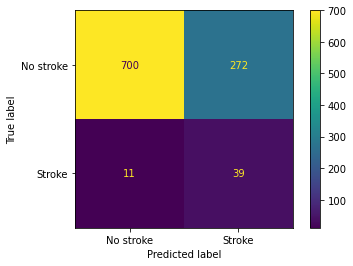

In [16]:
### CREATING THE FINAL MODEL
clf_rf = RandomForestClassifier(random_state = 99,
                               class_weight = 'balanced',
                               max_depth = 4,
                               max_features = 11,
                               min_samples_leaf = 20,
                               min_samples_split = 11,
                               n_estimators = 900,
                               oob_score = True,
                               n_jobs = -1)
clf_rf.fit(X_train, y_train)
plot_confusion_matrix(clf_rf, X_test, y_test, display_labels = ['No stroke', 'Stroke'])

Of the 50 stroke cases, the final model predicts 39 correctly while it fails to do the same for the other 11. This is actually similar to our previous model.

In [17]:
### CALCULATING ESSENTIAL METRICS
y_pred_rf = clf_rf.predict(X_test)
print(classification_report(y_test, y_pred_rf, target_names = ['No stroke', 'Stroke']))
print('Accuracy: %f' % accuracy_score(y_test, y_pred_rf))
print('Recall score: %f' % recall_score(y_test, y_pred_rf))
print('OOB error: %f' % (1 - clf_rf.oob_score_))

              precision    recall  f1-score   support

   No stroke       0.98      0.72      0.83       972
      Stroke       0.13      0.78      0.22        50

    accuracy                           0.72      1022
   macro avg       0.55      0.75      0.52      1022
weighted avg       0.94      0.72      0.80      1022

Accuracy: 0.723092
Recall score: 0.780000
OOB error: 0.256849


The recall score is still 78%, same as the last model. What changes here are the accuracy which is now about 72%, more than the previous model, and the OOB error which is now about 25.7%, less than the previous model. This means that this final model, in addition to being equivalent to the last one in terms of identifying true stroke cases, also does a slightly better job at identifying the non-stroke ones. Thus, it is comparatively a more stable model.

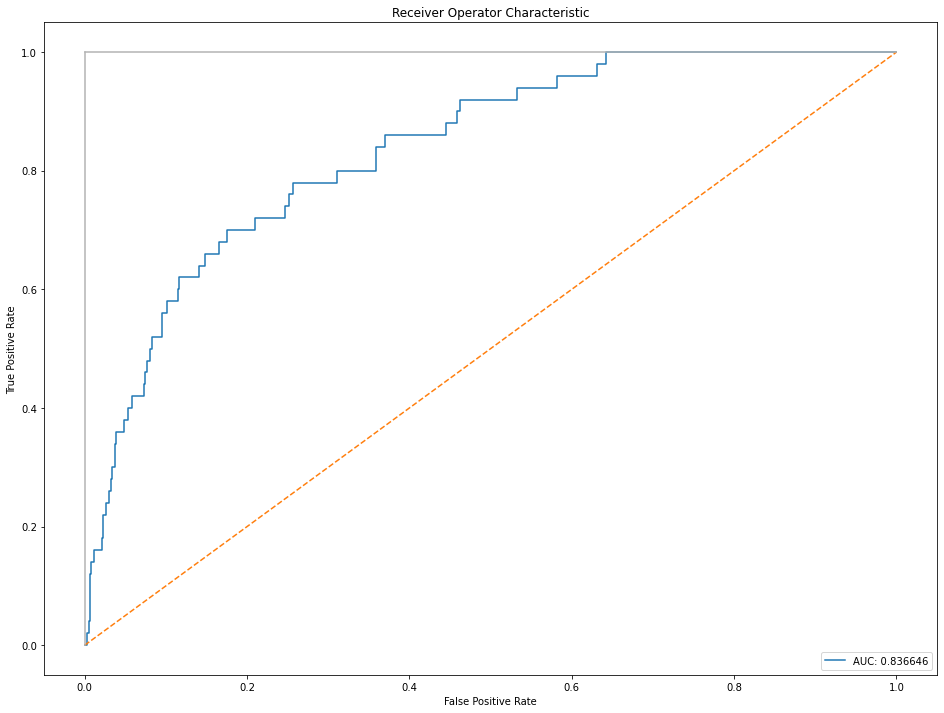

In [18]:
### PLOTTING ROC CURVE WITH AUC VALUE
y_prob_rf = clf_rf.predict_proba(X_test)[:, 1]
fpr, tpr, threshold = roc_curve(y_test, y_prob_rf)
roc_auc = roc_auc_score(y_test, y_prob_rf)
plt.figure(figsize = (16, 12))
plt.title('Receiver Operator Characteristic')
plt.plot(fpr, tpr, label = 'AUC: %f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], ls = '--')
plt.plot([0, 0], [1, 0], c = '0.7')
plt.plot([1, 1], c = '0.7')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

We get an AUC score of about 0.8366, which is not that different from our previous model.


We can also see the features deemed significant by the model.

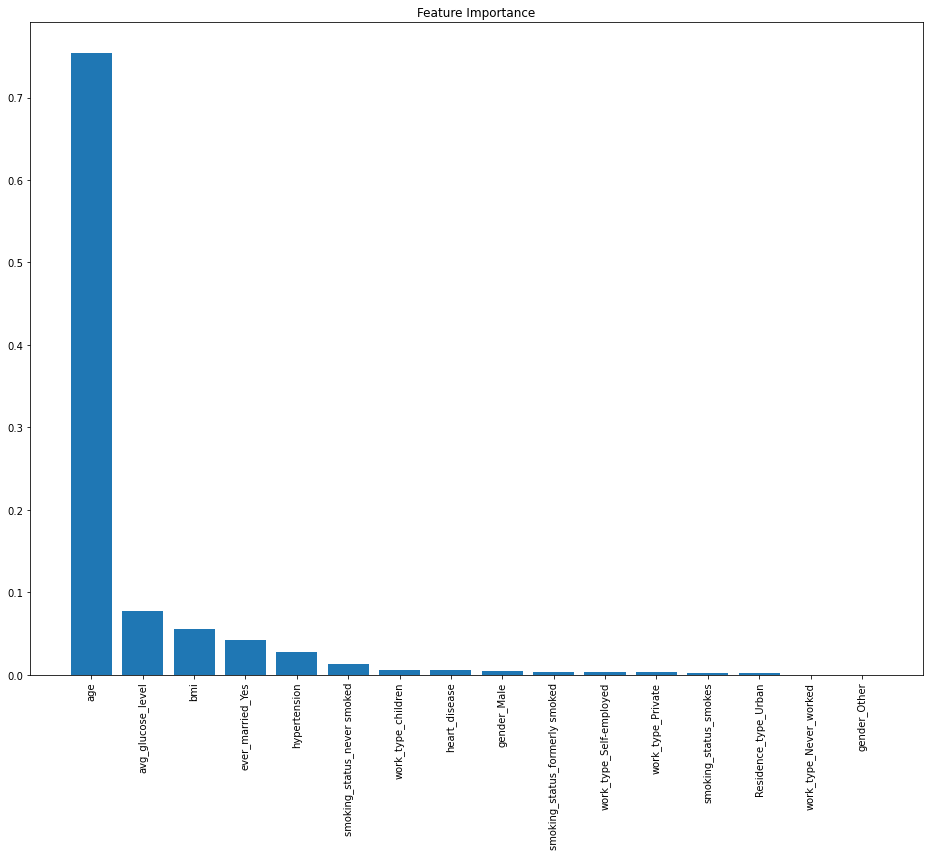

In [19]:
### PLOTTING FEATURE IMPORTANCE
importance = clf_rf.feature_importances_
indices = np.argsort(importance)[::-1]
names = [X.columns[i] for i in indices]
plt.figure(figsize = (16, 12))
plt.figure
plt.title('Feature Importance')
plt.bar(range(X.shape[1]), importance[indices])
plt.xticks(range(X.shape[1]), names, rotation = 90)
plt.show()

We again see that age is considered widely significant, next comes the average glucose level and then the bmi. Marital status and hypertension come next followed by non-smokers.